In [234]:
import numpy as np
from scipy import constants
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
from scipy.special import factorial
import functools
Ry_in_erg = constants.value('Rydberg constant times hc in J') * 1.e7  # in ergs
kb = constants.k * 1e7
h = constants.value('Planck constant') * 1e7  # in ergs s
c = constants.c * 1.e2  # in cm/s
e_e = 4.80320451e-10  # in statcoulomb
m_e = constants.electron_mass * 1e3  # in g

In [235]:
def G_l(l, m, eta, rho):
    """G matrix element, radial-dipole integral"""
    gl = 0
    for i in range(2 * m + 1):
        gl += b_s(i, l, m, eta, rho) * rho**i

    return gl


@functools.lru_cache(maxsize=2048)
def b_s(s, l, m, eta, rho):
    """polynomial solution to matrix element G_l"""
    if s == 0:
        return 1
    if s == 1:
        return 2 * m * eta / l

    bsminus1 = b_s(s - 1, l, m, eta, rho)
    bsminus2 = b_s(s - 2, l, m, eta, rho)
    bs = -(1 / (s * (s + 2 * l - 1))) * (4 * eta * (s - 1 - m) *
                                         bsminus1 + (2 * m + 2. - s) * (2 * m + 2 * l + 1 - s) * bsminus2)
    return bs

In [236]:
def sigma_minus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l-1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    nu = E / h

    if l == 0:
        return 0

    rho = eta / n

    GlA = G_l(l, -(l + 1 - n), eta, rho)
    GlB = G_l(l, -(l - 1 - n), eta, rho)

    prefactor = 2**(4 * l) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(1, l):
        A *= (l_i**2 + eta**2)
    B = l**2 * factorial(n + l) / factorial(2 * l + 1) / \
        factorial(2 * l - 1) / factorial(n - l - 1)
    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 2) / (1 + rho**2)**(2 * n - 2)
    E = (GlA - (1 + rho**2)**(-2) * GlB)**2
    return prefactor * A * B * C * D * E


def sigma_plus(n, l, E, Z):
    """Cross section for bound-free absorption from (n, l) through
    dipole transition to E with angular momentum l+1"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    GlA = G_l(l + 1, -(l + 1 - n), eta, rho)
    GlB = G_l(l + 1, -(l - n), eta, rho)

    prefactor = 2**(4 * l + 6) / 3 * np.pi * e_e**2 / m_e / c / nu

    A = 1
    for l_i in range(l + 1):
        A *= ((l_i + 1)**2 + eta**2)
    B = (l + 1)**2 * factorial(n + l) / (2 * l + 1) / factorial(2 * l + 1) / \
        factorial(2 * l + 2) / factorial(n - l - 1) / ((l + 1)**2 + eta**2)**2

    C = np.exp(-4 * eta * np.arctan2(1, rho)) / (1 - np.exp(-2 * np.pi * eta))
    D = rho**(2 * l + 4) * eta**2 / (1 + rho**2)**(2 * n)
    E = ((l + 1 - n) * GlA + (l + 1 + n) / (1 + rho**2) * GlB)**2
    return prefactor * A * B * C * D * E

In [237]:
#@functools.lru_cache(maxsize=2048)
def sigma_bf_nl(n, l, nu, Z):
    """Bound-free cross section for absorption from (n, l) through
    dipole transition to E with angular momenta l+-1"""
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    return sigma_plus(n, l, h * nu, Z) + sigma_minus(n, l, h * nu, Z)


@functools.lru_cache(maxsize=2048)
def sigma_bf_n(n, Z, nu):
    """angular momentum-average Bound-free cross section from 
    n through dipole transition to E with """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    sbf = 0
    for l in range(n):
        sbf += (2 * l + 1) * sigma_bf_nl(n, l, nu, Z)

    return sbf / n**2

In [238]:
def gaunt_bound_free_nl(nu, n, l, Z):
    """ratio of the cross section for bound-free absorption from 
    a bound state (n, l) to a free (continuum) state E with 
    unpolarized photon E_ph and the Kramers' semi-classical 
    bound-free cross section

    Arguments:
    n    : Principal quantum number
    l    : Azimuthal quantum number
    nu   : frequency of unpolarized photon
    Z    : ionization state

    Returns:
    g_bf : (n,l,nu) Gaunt factor for bound-free transitions
    """
    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    sp = sigma_plus(n, l, h * nu, Z)
    sm = sigma_minus(n, l, h * nu, Z)
    sK = sigma_K(n, h * nu, Z)
    return (sp + sm) / sK

def sigma_K(n, E, Z):
    """Kramers' semi-classical bound-free cross section"""
    eta = (Z**2 * Ry_in_erg / E)**.5
    rho = eta / n
    nu = E / h
    return 2.**4 / 3. / 3.**.5 * (e_e**2 / m_e / c / nu) / n * (rho**2 / (1 + rho**2))**2

def gaunt_bound_free_n(nu, n, Z):

    if h * nu < Z**2 * Ry_in_erg / n**2:
        return 0.
    gbf = 0
    for l in range(n):
        gbf += (2 * l + 1) * gaunt_bound_free_nl(nu, n, l, Z)

    return gbf / n**2

In [239]:
def gamma_fb_n(n, Z, nu, T):
    """emission coefficient of single-shell bound-free transition for
    an ensemble of electrons at temperature T"""
    I_n = Z**2 * Ry_in_erg / n**2
    E = h*nu
    if E < I_n:
        return 0
    else:
        epsilon = h * nu / Z**2 / Ry_in_erg - 1/n**2
        pre = 7.907e-18 * (n / Z**2) * (1 + n**2 * epsilon)**(-3)
        g = gaunt_bound_free_n(nu, n, Z)
        
    A = (2 / np.pi)**.5
    B = np.exp(I_n / kb / T) / \
        c**2 / (m_e * kb * T)**(3 / 2)
    C = 2 * n**2 * h * (h * nu)**3

    E = np.exp(-h * nu / kb / T)

    return A * B * C * pre*g * E

In [240]:
def j_nu_fb(n, Z, nu, T, n_i, n_e):
    """emission coefficient of shell-sum bound-free transition"""
    # return 1/4/np.pi * n_i * n_e * sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])
    return sum([gamma_fb_n(i, Z, nu, T) for i in range(1, n)])

In [241]:
test = []
for nu in np.logspace(np.log10(3e13), np.log10(3e15), 200):
    test.append(nu * j_nu_fb(20, 1, nu, 10000, 1e4, 1e4))

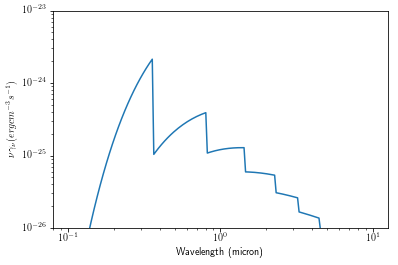

In [242]:
plt.loglog(3e14 / np.logspace(np.log10(3e13),
                              np.log10(3e15), 200),  np.array(test))
plt.ylim(1e-26, 1e-23)
plt.ylabel(r'\nu \gamma_{\nu} (erg cm^{-3}s^{-1})')
plt.xlabel('Wavelength (micron)')